# Box-Plots for Education

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.scorer import make_scorer

In [2]:
from multilabel import multilabel_train_test_split
from SparseInteractions import SparseInteractions
from metrics import multi_multi_log_loss

# Function

In [3]:
# Show more observations and columns when print the dataframe
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Load Data

In [4]:
# load the data
df = pd.read_csv("TrainingData.csv", index_col=0)
display_all(df)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,KINDERGARTEN,50471.810000,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860000,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.00000,NaN,NaN,TEACHER,62237.130000,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300000,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166000,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109283,Professional Development,ISPD,Shared Services,Non-School,Unspecified,Instructional Coach,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,WORKSHOP PARTICIPANT,NaN,NaN,CURRICULUM RESOURCE TEACHER,NaN,NaN,NaN,STAFF DEV AND INSTR MEDIA,NaN,INST STAFF TRAINING SVCS,NaN,NaN,48.620000,NaN,GENERAL FUND,STAFF DEV AND INSTR MEDIA
102430,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,NaN,FEDERAL GDPG FUND - FY,"Teacher,Retrd Shrt Term Sub",Regular,NaN,NaN,NaN,0.00431,"TITLE II,D",NaN,PROFESSIONAL-INSTRUCTIONAL,128.824985,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
413949,Parent & Community Relations,NO_LABEL,School Reported,School,NO_LABEL,Other,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,School Liaison,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,PARENT/TITLE I,4902.290000,Misc,Schoolwide Schools,NaN
433672,Library & Media,Instruction,School on Central Budgets,Non-School,Unspecified,Librarian,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,EDUCATIONAL RESOURCE SERVICES,LEVY OVERRIDE,Library Technician II,NaN,NaN,NaN,ED RESOURCE SERVICES,NaN,NON-PROJECT,NaN,OFFICE/ADMINISTRATIVE SUPPORT,4020.290000,MEDIA SUPPORT SERVICES,NaN,INSTRUCTIONAL STAFF


# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

In [6]:
# Number of types of categories
df.dtypes.value_counts()

object     23
float64     2
dtype: int64

### Missing Values

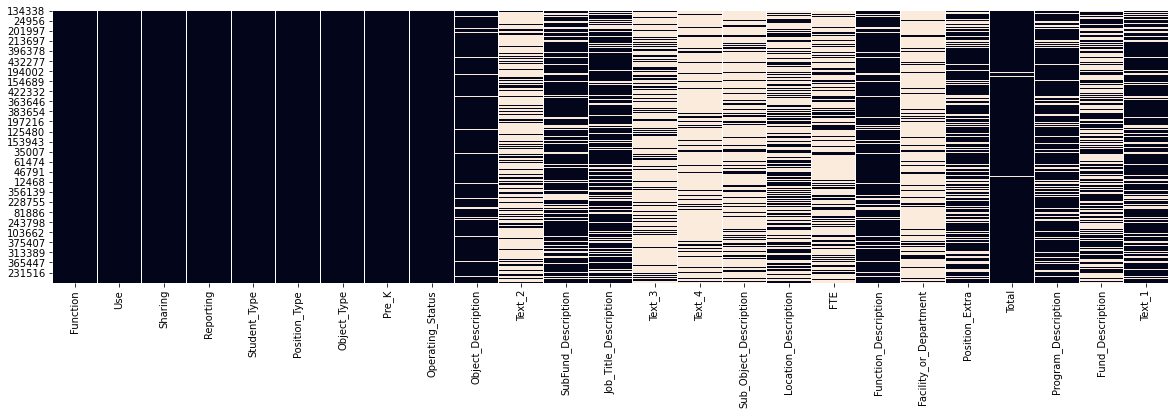

In [7]:
# Show the missing values in a graph
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

## Analysis of Numerical Variables

In [8]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


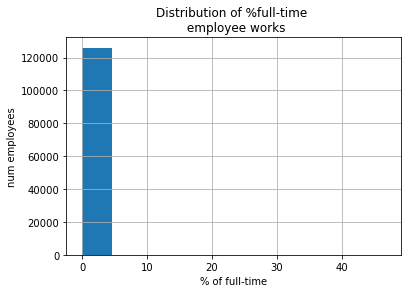

In [9]:
# Graph of Distribution of %full-time vs employee works
df['FTE'].dropna().hist()

plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

plt.show()

In [10]:
# Number of FTE observations bigger than 1
(df['FTE'] > 1).sum()

3068

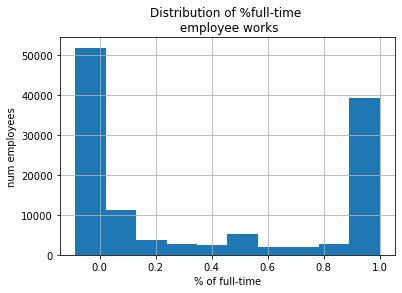

In [11]:
# Graph of Distribution of %full-time vs employee works
df['FTE'][df['FTE'] <= 1].dropna().hist()

plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

plt.show()

In [12]:
#change all values bigger than 1 for the mean
df['FTE'].loc[df['FTE'] > 1] = df['FTE'].mean()

In [13]:
(df['FTE'] > 1).sum()

0

In [14]:
df[['FTE','Total']].isna().sum()

FTE      274206
Total      4555
dtype: int64

In [15]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
numeric_columns

['FTE', 'Total']

## Analysis and Preprocessing of Label Variables

In [16]:
labels = ['Function',
          'Use',
          'Sharing',
          'Reporting',
          'Student_Type',
          'Position_Type',
          'Object_Type', 
          'Pre_K',
          'Operating_Status']

categorize_label = lambda x: x.astype('category')

In [17]:
df[labels] = df[labels].apply(categorize_label, axis=0)
print(df[labels].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


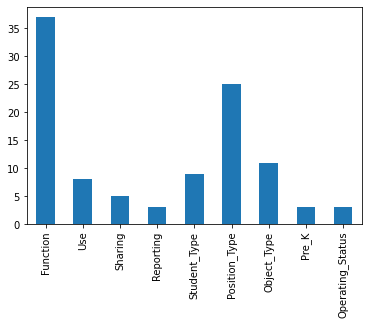

In [18]:
# Grpah with the count of categories perlabel
num_unique_labels = df[labels].apply(lambda x: pd.Series.nunique(x), axis=0)
num_unique_labels.plot(kind='bar')
plt.show()

In [19]:
# Get all the categories in each label feature
for label in df[labels].columns:
    print(label, ': ', df[label].unique(), end='\n')
    print('')

Function :  ['Teacher Compensation', 'NO_LABEL', 'Substitute Compensation', 'Facilities & Maintenance', 'Instructional Materials & Supplies', ..., 'Recruitment', 'Insurance', 'Untracked Budget Set-Aside', 'Communications', 'Facilities Planning']
Length: 37
Categories (37, object): ['Teacher Compensation', 'NO_LABEL', 'Substitute Compensation', 'Facilities & Maintenance', ..., 'Insurance', 'Untracked Budget Set-Aside', 'Communications', 'Facilities Planning']

Use :  ['Instruction', 'NO_LABEL', 'O&M', 'Pupil Services & Enrichment', 'ISPD', 'Leadership', 'Business Services', 'Untracked Budget Set-Aside']
Categories (8, object): ['Instruction', 'NO_LABEL', 'O&M', 'Pupil Services & Enrichment', 'ISPD', 'Leadership', 'Business Services', 'Untracked Budget Set-Aside']

Sharing :  ['School Reported', 'NO_LABEL', 'School on Central Budgets', 'Leadership & Management', 'Shared Services']
Categories (5, object): ['School Reported', 'NO_LABEL', 'School on Central Budgets', 'Leadership & Managemen

In [20]:
# Get all the Operating_Status equal to Operating_Status
OpStatus = df[labels][df['Operating_Status'] == 'Non-Operating']
OpStatus

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
304569,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
64760,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
43727,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
5614,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
...,...,...,...,...,...,...,...,...,...
292626,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
203453,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
446383,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
397424,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating


In [21]:
# Check if all the other label are equal to NO_LABEL
(OpStatus == 'NO_LABEL').sum()

Function            48034
Use                 48034
Sharing             48034
Reporting           48034
Student_Type        48034
Position_Type       48034
Object_Type         48034
Pre_K               48034
Operating_Status        0
dtype: int64

# Function

In [22]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=numeric_columns + labels):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

## Analysis and Preprocessing of Categorical Variables

In [23]:
# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 4757 tokens in the dataset
There are 3284 alpha-numeric tokens in the dataset


## Models with different preprocessing

In [24]:
# Get the columns that are features in the original df
non_labels = [c for c in df.columns if c not in labels]
non_labels

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [25]:
# Get the label as dummy variables
label_dummies = pd.get_dummies(df[labels])
label_dummies

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
364634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
102430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
413949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
433672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [26]:
# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[non_labels],
                                                               label_dummies,
                                                               0.3, 
                                                               seed=27)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[numeric_columns], validate=False)

In [27]:
get_text_data.fit_transform(df.head())

134338       Teacher-Elementary        KINDERGARTEN  KIN...
206341    CONTRACTOR SERVICES BOND EXPENDITURES BUILDING...
326408    Personal Services - Teachers   TCHER 2ND GRADE...
364634    EMPLOYEE BENEFITS TEACHER SUBS GENERAL FUND Te...
47683     TEACHER COVERAGE FOR TEACHER TEACHER SUBS GENE...
dtype: object

In [28]:
get_numeric_data.fit_transform(df.head())

,FTE,Total
134338,1.0,50471.810
206341,NaN,3477.860
326408,1.0,62237.130
364634,NaN,22.300
47683,NaN,54.166


In [29]:
%%time

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC))
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  1.665514685675741e-05
Wall time: 4min 58s


In [31]:
log_loss_scorer = make_scorer(multi_multi_log_loss)

# print the score of our trained pipeline on our test set
print("Logloss score of trained pipeline: ", log_loss_scorer(pl, X_test, y_test.values))

Logloss score of trained pipeline:  6.305897578342128


In [32]:
%%time

# Select 300 best features
chi_k = 300

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.7740895880349425
Wall time: 47min 35s


In [33]:
# print the score of our trained pipeline on our test set
print("Logloss score of numeric model: ", log_loss_scorer(pl, X_test, y_test.values))

Logloss score of numeric model:  2.0149715094374314


In [34]:
%%time

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     alternate_sign=False, norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.76721933995653
Wall time: 44min 16s


In [35]:
# print the score of our trained pipeline on our test set
print("Logloss score of numeric model: ", log_loss_scorer(pl, X_test, y_test.values))

Logloss score of numeric model:  1.9882984148746377


In [39]:
# Make predictions
predictions = pl.predict_proba(X_test)

# Format correctly in new DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[labels]).columns,
                             index=X_test.index,
                             data=predictions)

prediction_df

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
206341,3.731666e-04,7.035810e-03,7.034470e-04,4.392115e-03,8.659854e-03,1.046389e-03,1.070632e-02,1.519209e-02,5.497026e-03,0.000015,...,2.871052e-02,3.269903e-03,9.122577e-03,7.342187e-03,0.963520,2.838771e-02,5.234205e-03,7.567854e-01,7.875491e-03,0.209013
364634,1.981886e-09,1.128715e-08,6.799256e-07,1.697646e-08,4.315670e-11,6.637520e-07,3.348042e-08,6.394045e-06,8.588747e-10,0.000001,...,1.834324e-07,3.800698e-06,6.005320e-10,1.270784e-07,1.000000,1.884060e-12,1.088215e-11,1.902758e-06,2.476029e-08,1.000000
47683,2.148890e-04,2.725640e-06,1.782429e-06,1.451280e-06,6.823192e-08,3.741046e-06,2.219915e-06,4.247470e-04,3.620026e-07,0.000009,...,3.924825e-07,9.999862e-01,6.951429e-07,1.306219e-05,0.999999,6.670995e-09,2.013918e-05,1.272423e-06,1.035451e-05,0.999999
417668,8.942776e-04,1.319779e-04,4.578452e-05,2.759186e-05,2.571996e-05,3.968774e-04,2.424365e-04,5.998595e-04,1.943313e-04,0.000012,...,1.059549e-04,3.765072e-05,9.402044e-01,1.364571e-04,0.962609,2.304629e-03,2.548673e-02,7.268682e-02,1.560081e-02,0.932701
64760,8.842961e-05,1.475940e-05,5.081150e-07,2.041938e-09,8.110007e-07,1.630552e-07,1.765586e-07,4.250315e-08,2.388156e-07,0.000001,...,2.519756e-07,1.842969e-07,9.395598e-09,1.091039e-08,0.999999,4.069648e-06,4.828755e-09,9.999998e-01,1.253208e-09,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70455,3.122767e-03,2.937786e-04,1.500433e-04,5.619704e-05,1.783281e-04,2.275309e-04,4.243178e-04,6.001965e-05,4.842146e-05,0.000014,...,1.588585e-04,1.155564e-04,3.818176e-04,2.348501e-04,0.998881,3.004889e-04,1.527811e-03,2.285364e-03,9.792302e-01,0.025057
72072,2.683175e-03,1.021823e-04,2.439980e-04,3.041618e-04,4.965961e-04,2.958010e-04,3.201713e-06,9.037660e-08,1.701639e-04,0.000011,...,1.490971e-05,8.385182e-06,9.806257e-06,8.621421e-05,0.001138,9.991683e-01,2.103537e-04,1.183591e-05,2.152188e-04,0.998574
225892,7.290803e-05,1.255349e-05,3.066901e-06,2.196314e-06,8.618291e-06,8.726520e-07,1.861918e-04,7.827331e-07,1.308950e-05,0.000004,...,4.213264e-07,5.436750e-07,3.714744e-08,1.436045e-07,1.000000,3.629074e-11,8.981064e-08,6.486620e-06,1.886329e-07,0.999990
155111,1.258909e-05,3.247722e-05,6.927490e-06,4.040361e-05,1.704046e-06,1.898330e-06,2.750729e-05,7.956305e-11,3.746062e-05,0.000004,...,9.023391e-09,5.010005e-08,5.765271e-09,5.639374e-06,0.007625,9.870357e-01,1.563031e-05,4.673726e-03,7.850093e-07,0.993439


## Submission

In [40]:
# Load holdout data
holdout = pd.read_csv("TestData.csv", index_col=0)

# Make predictions
predictions = pl.predict_proba(holdout)

# Format correctly in new DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[labels]).columns,
                             index=holdout.index,
                             data=predictions)


# Save prediction_df to csv called "predictions.csv"
prediction_df.to_csv("predictions.csv")

In [41]:
prediction_df

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
180042,0.000293,0.000422,0.000052,0.000923,0.007043,0.000314,0.046529,2.300020e-04,0.002302,0.000040,...,1.229439e-02,1.617176e-05,0.780307,0.000530,0.997906,2.373313e-03,0.000361,0.000807,0.039624,0.962675
28872,0.000361,0.000280,0.000102,0.000220,0.000353,0.000176,0.997036,4.376395e-04,0.000675,0.000057,...,5.596150e-04,2.818457e-09,0.006642,0.000943,0.014962,5.359421e-01,0.001084,0.000013,0.000111,0.999965
186915,0.035909,0.001429,0.000047,0.000540,0.000097,0.000042,0.004101,1.909915e-07,0.001331,0.000047,...,6.070647e-05,4.288997e-08,0.013696,0.000015,0.991305,3.877661e-04,0.000788,0.000202,0.049618,0.980804
412396,0.035876,0.001429,0.000047,0.000540,0.000097,0.000042,0.004099,1.910545e-07,0.001330,0.000047,...,6.066906e-05,4.290608e-08,0.013681,0.000015,0.991306,3.877579e-04,0.000787,0.000202,0.049710,0.980766
427740,0.001569,0.000423,0.000530,0.000015,0.000292,0.000164,0.018166,4.499051e-07,0.000068,0.000195,...,4.710796e-07,1.411734e-08,0.000052,0.000018,0.451896,1.168363e-03,0.003031,0.001049,0.000008,0.999250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169063,0.001284,0.000756,0.000222,0.004006,0.012837,0.000844,0.008971,1.152205e-03,0.005951,0.000092,...,1.374985e-02,1.818031e-03,0.014371,0.007712,0.996803,6.518461e-06,0.004796,0.008157,0.004620,0.989046
433255,0.001259,0.000755,0.000223,0.003883,0.012245,0.000836,0.008575,1.080034e-03,0.005771,0.000093,...,1.302024e-02,1.745978e-03,0.013559,0.007378,0.996857,6.186102e-06,0.004775,0.007739,0.004445,0.989723
232204,0.001031,0.002044,0.000337,0.003278,0.005819,0.000807,0.002554,4.637802e-05,0.007535,0.000131,...,2.313497e-03,2.874532e-04,0.002098,0.001895,0.998076,9.720274e-07,0.003174,0.001443,0.001120,0.998464
171685,0.001257,0.000752,0.000222,0.003869,0.012194,0.000835,0.008552,1.079788e-03,0.005744,0.000093,...,1.298661e-02,1.744997e-03,0.013522,0.007362,0.996860,6.173996e-06,0.004777,0.007720,0.004438,0.989757
